# Tutorial 104: Time Series with Pandas / NumPy

Contributed by: Avi Thaker https://github.com/athaker/CNTK
November 20, 2016

This tutorial will introduce the use of the Cognitive Toolkit for time series data. We show how to prepare time series data for deep learning algorithms. We will cover training a neural network and evaluating the neural network model. We will also look at the predictive potential on classification of an Exchange-traded Funds ([ETF](https://en.wikipedia.org/wiki/Exchange-traded_fund)), and in this simplified setting how one could trade it. This tutorial serves **only** as an example of how to use neural networks for time series analysis. 
    
It is important to note that the stock market is extremely noisy and is difficult to predict. This is best done by professionals with domain expertise. It is more important to make sure the model is correct before setting up a trading system (there are many factors to consider including but not limited to: [curve fitting bias](https://en.wikipedia.org/wiki/Overfitting), [forward looking bias](http://www.investopedia.com/terms/l/lookaheadbias.asp?lgl=no-infinite), profitability etc.). The learnings and anecdotes presented in this tutorial is only for exemplary purposes with the goal of introducing an approach to analyze time series data.

This tutorial introduces how to use pandas_datareader package and pandas. Please note, this tutorial will utilize the numpy interface to CNTK which interfaces well with [Pandas dataframes](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) (a structure that is well suited towards timeseries analysis). 


In [1]:
from __future__ import print_function
import datetime
import numpy as np
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import cntk as C

%matplotlib inline

In the block below, we check if we are running this notebook in the CNTK internal test machines by looking for environment variables defined there. We then select the right target device (GPU vs CPU) to test this notebook. In other cases, we use CNTK's default policy to use the best available device (GPU, if available, else CPU).

In [2]:
# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(C.device.cpu())
    else:
        C.device.try_set_default_device(C.device.gpu(0))

## Importing stock data
We first retrieve stock data using the method `get_stock_data`. This method downloads stock data on a daily timescale from Yahoo finance (can be modified to get data from Google Finance and many other sources). [Pandas datareader]( http://pandas-datareader.readthedocs.io/en/latest/remote_data.html) shows many use cases for this data reader.

In [3]:
# A method which obtains stock data from Yahoo finance
# Requires that you have an internet connection to retreive stock data from Yahoo finance
import time
try:
    from pandas_datareader import data
except ImportError:
    !pip install pandas_datareader
    from pandas_datareader import data

def get_stock_data(contract, s_year, s_month, s_day, e_year, e_month, e_day):
    """
    Args:
        contract (str): the name of the stock/etf
        s_year (int): start year for data
        s_month (int): start month
        s_day (int): start day
        e_year (int): end year
        e_month (int): end month
        e_day (int): end day
    Returns:
        Pandas Dataframe: Daily OHLCV bars
    """
    start = datetime.datetime(s_year, s_month, s_day)
    end = datetime.datetime(e_year, e_month, e_day)
    
    retry_cnt, max_num_retry = 0, 3
    
    while(retry_cnt < max_num_retry):
        try:
            bars = data.get_data_yahoo(contract, start, end)
            return bars
        except:
            retry_cnt += 1
            time.sleep(np.random.randint(1,10)) 
            
    print("Yahoo Finance is not reachable")
    return None

In [4]:
import pickle as  pkl

# We search in cached stock data set with symbol SPY.               
# Check for an environment variable defined in CNTK's test infrastructure
envvar = 'CNTK_EXTERNAL_TESTDATA_SOURCE_DIRECTORY'
def is_test(): return envvar in os.environ

def download(data_file):
    data = get_stock_data("SPY", 2000, 1,2,2017,1,1)
    dir = os.path.dirname(data_file)
        
    if not os.path.exists(dir):
        os.makedirs(dir)
        
    if not os.path.isfile(data_file):
        print("Saving", data_file )
        with open(data_file, 'wb') as f:
            pkl.dump(data, f, protocol = 2)
    return data

data_file = os.path.join("data", "Stock", "stock_SPY.pkl")

# Check for data in local cache
if os.path.exists(data_file):
        print("File already exists", data_file)
        data = pd.read_pickle(data_file) 
else: 
    # If not there we might be running in CNTK's test infrastructure
    if is_test():
        test_file = os.path.join(os.environ[envvar], 'Tutorials','data','stock','stock_SPY.pkl')
        if os.path.isfile(test_file):
            print("Reading data from test data directory")
            data = pd.read_pickle(test_file)
        else:
            print("Test data directory missing file", test_file)
            print("Downloading data from Yahoo Finance")
            data = download(data_file)         
    else:
        # Local cache is not present and not test env
        # download the data from Yahoo finance and cache it in a local directory
        # Please check if there is trade data for the chosen stock symbol during this period
        data = download(data_file)

Test data directory missing file c:\Data\CNTKTestData\Tutorials\data\stock\stock_SPY.pkl
Saving data\Stock\stock_SPY.pkl


## Building the training paramaters

The stock market behavior exhibits substantial [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) ([reference](http://epchan.blogspot.com/2016/04/mean-reversion-momentum-and-volatility.html)). We use [ETF](http://www.investopedia.com/terms/e/etf.asp) `SPY` index representing the "market" of stock. This is the ETF that encompasses around top 500 companies in America by market capitalization. We will trade under the assumption that there is some short term autocorrelation that have predictive power in the market. 

### Predicting
* Whether or not the next data for the given stock/ETF will be above or below the current day.

### Predictors
* The previous 8 days, classified if greater than the current day,

* The volume changes as a percentage,

* The percentage change from the previous day.

Note, we are not feeding the neural network the price itself. Financial timeseries data are noisy. It is important not to overfit the data. There is a lot we can do here (smoothing, adding more features, etc.), but we will keep this tutorial simple, and demonstrate CNTK's ability to interface with timeseries data. 

In [5]:
# Feature name list
predictor_names = []

# Compute price difference as a feature
data["diff"] = np.abs((data["Close"] - data["Close"].shift(1)) / data["Close"]).fillna(0) 
predictor_names.append("diff")

# Compute the volume difference as a feature
data["v_diff"] = np.abs((data["Volume"] - data["Volume"].shift(1)) / data["Volume"]).fillna(0) 
predictor_names.append("v_diff")

# Compute the stock being up (1) or down (0) over different day offsets compared to current dat closing price
num_days_back = 8

for i in range(1,num_days_back+1):
    data["p_" + str(i)] = np.where(data["Close"] > data["Close"].shift(i), 1, 0) # i: number of look back days
    predictor_names.append("p_" + str(i))
    

    
# If you want to save the file to your local drive
#data.to_csv("PATH_TO_SAVE.csv")
data.head(10)

,Open,High,Low,Close,Volume,Adj Close,diff,v_diff,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8
Date,,,,,,,,,,,,,,,,
2000-01-03,148.250000,148.250000,143.875000,145.437500,8164300,105.366938,0.000000,0.000000,0,0,0,0,0,0,0,0
2000-01-04,143.531204,144.062500,139.640594,139.750000,8089800,101.246443,0.040698,0.009209,0,0,0,0,0,0,0,0
2000-01-05,139.937500,141.531204,137.250000,140.000000,12177900,101.427563,0.001786,0.335698,1,0,0,0,0,0,0,0
2000-01-06,139.625000,141.500000,137.750000,137.750000,6227200,99.797478,0.016334,0.955598,0,0,0,0,0,0,0,0
2000-01-07,140.312500,145.750000,140.062500,145.750000,8066500,105.593338,0.054889,0.228017,1,1,1,1,0,0,0,0
2000-01-10,146.250000,146.906204,145.031204,146.250000,5741700,105.955580,0.003419,0.404898,1,1,1,1,1,0,0,0
2000-01-11,145.812500,146.093704,143.500000,144.500000,7503700,104.687735,0.012111,0.234817,0,0,1,1,1,0,0,0
2000-01-12,144.593704,144.593704,142.875000,143.062500,6907700,103.646291,0.010048,0.086281,0,0,0,1,1,1,0,0
2000-01-13,144.468704,145.750000,143.281204,145.000000,5158300,105.049976,0.013362,0.339143,1,1,0,0,1,1,1,0


### What we are trying to predict

Here we are trying to predict whether or not the next days' trading will be above or below the current day. We will represent a predicted up day as a 1, else a 0 if the next day is the same or below. (Note: the market is unlikely going to close at the same price as it did the previous day). 

In [6]:
data["next_day"] = np.where(data["Close"].shift(-1) > data["Close"], 1, 0)
data["next_day_opposite"] = np.where(data["next_day"]==1,0,1) # The label must be one-hot encoded

# Establish the start and end date of our training timeseries (picked 2000 days before the market crash)
training_data = data["2000-01-15":"2008-01-01"]

# We define our test data as: data["2008-01-02":]
# This example allows to to include data up to current date

test_data = data["2008-01-02":"2016-11-25"] 
training_features = np.asarray(training_data[predictor_names], dtype = "float32")
training_labels = np.asarray(training_data[["next_day","next_day_opposite"]], dtype="float32")

Here we are actually building the neural network itself. We will use a simple feedforward neural network (represented as `NN` in the plots) with 10 inputs and 50 dimensions.

**Suggested exercise** Try experimenting here with different sizes and number of hidden layers. What happens when we make this network large? Do we overfit the data? 

In [7]:
print(training_features.shape)

(2000, 10)


Note, we are using `layers` library in this tutorial. The details documentation can be found [here](https://cntk.ai/pythondocs/layerref.html).

In [8]:
# Lets build the network
input_dim = 2 + num_days_back
num_output_classes = 2 #Remember we need to have 2 since we are trying to classify if the market goes up or down 1 hot encoded
num_hidden_layers = 2
hidden_layers_dim = 2 + num_days_back
input_dynamic_axes = [C.Axis.default_batch_axis()]
input = C.input(input_dim, dynamic_axes=input_dynamic_axes)
label = C.input(num_output_classes, dynamic_axes=input_dynamic_axes)

def create_model(input, num_output_classes):
    h = input
    with C.layers.default_options(init = C.glorot_uniform()):
        for i in range(0,num_hidden_layers):
            h = C.layers.Dense(hidden_layers_dim, 
                               activation = C.relu)(h)
        r = C.layers.Dense(num_output_classes, activation=None)(h)   
    return r
    
z = create_model(input, num_output_classes)
loss = C.cross_entropy_with_softmax(z, label)
label_error = C.classification_error(z, label)
lr_per_minibatch = C.learning_rate_schedule(0.125,C.UnitType.minibatch)
trainer = C.Trainer(z, (loss, label_error), [C.sgd(z.parameters, lr=lr_per_minibatch)])

In [9]:
#Initialize the parameters for the trainer, we will train in large minibatches in sequential order
minibatch_size = 100
num_minibatches = len(training_data.index) // minibatch_size

#Run the trainer on and perform model training
training_progress_output_freq = 1

# Visualize the loss over minibatch
plotdata = {"batchsize":[], "loss":[], "error":[]}

## Number of passes through the data, how we train time series data
This tutorial will differ from other tutorials in the sense that here we will not randomly send data to the trainer, instead each minibatch will be fed sequentially in the order of the time dimension. This is key to time series data-handling where we want to "weigh" the data at the end of our sample a slightly higher. You can put in multiple passes, however you will notice significant performance degradation. Try it out! Additionally, multiple passes tend to overfit the financial timeseries data. This overfitting can be mitigated using standard ML approaches such as [L1 regularization](https://en.wikipedia.org/wiki/Regularization_%28mathematics%29).

In [10]:
tf = np.split(training_features,num_minibatches)

print("Number of mini batches")
print(len(tf))

print("The shape of the training feature minibatch")
print(tf[0].shape)

tl = np.split(training_labels, num_minibatches)

# It is key that we make only one pass through the data linearly in time
num_passes = 1 

# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"
    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
    return mb, training_loss, eval_error

Number of mini batches
20
The shape of the training feature minibatch
(100, 10)


In [11]:
# Train our neural network
tf = np.split(training_features,num_minibatches)
tl = np.split(training_labels, num_minibatches)

for i in range(num_minibatches*num_passes): # multiply by the 
    features = np.ascontiguousarray(tf[i%num_minibatches])
    labels = np.ascontiguousarray(tl[i%num_minibatches])
    
    # Specify the mapping of input variables in the model to actual minibatch data to be trained with
    trainer.train_minibatch({input : features, label : labels})
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 0.8458, Error: 52.00%
Minibatch: 1, Loss: 0.7292, Error: 53.00%
Minibatch: 2, Loss: 0.7177, Error: 52.00%
Minibatch: 3, Loss: 0.7022, Error: 52.00%
Minibatch: 4, Loss: 0.7118, Error: 53.00%
Minibatch: 5, Loss: 0.7118, Error: 53.00%
Minibatch: 6, Loss: 0.6900, Error: 44.00%
Minibatch: 7, Loss: 0.7228, Error: 61.00%
Minibatch: 8, Loss: 0.7242, Error: 61.00%
Minibatch: 9, Loss: 0.7087, Error: 48.00%
Minibatch: 10, Loss: 0.7006, Error: 54.00%
Minibatch: 11, Loss: 0.7013, Error: 54.00%
Minibatch: 12, Loss: 0.6948, Error: 53.00%
Minibatch: 13, Loss: 0.7122, Error: 56.00%
Minibatch: 14, Loss: 0.6950, Error: 49.00%
Minibatch: 15, Loss: 0.7011, Error: 55.00%
Minibatch: 16, Loss: 0.7015, Error: 48.00%
Minibatch: 17, Loss: 0.6794, Error: 46.00%
Minibatch: 18, Loss: 0.6874, Error: 49.00%
Minibatch: 19, Loss: 0.7077, Error: 49.00%


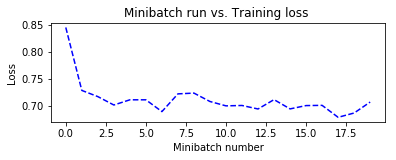

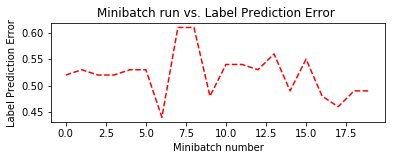

In [12]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["loss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss ')
plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["error"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error ')
plt.show()

Notice the trend for the label prediction error is still close to 50%. Remember that this is time variant, therefore it is expected that the system will have some noise as it trains through time. It should be noted; the model is still learning the market. Additionally, since this time series data is so noisy, having an error rate below 50% is good (many trading firms have win-rates of near 50% and have made money nearly every day [VIRTU](https://en.wikipedia.org/wiki/Virtu_Financial#Trading_activity)). However note they are high frequency trading firm and can leverage themselves up with low winrate strategies (51%). Trying to classify and trade every single day is expensive from transaction fees perspective. Therefore, one approach would be to trade when we think we are more likely to win?

Let us try this idea.

In [13]:
# Now that we have trained the net, and we will do out of sample test to see how we did.
# and then more importantly analyze how that set did

test_features = np.ascontiguousarray(test_data[predictor_names], dtype = "float32")
test_labels = np.ascontiguousarray(test_data[["next_day","next_day_opposite"]], dtype="float32")

avg_error = trainer.test_minibatch({input : test_features, label : test_labels})
print("Average error: {0:2.2f}%".format(avg_error * 100))

Average error: 49.00%


Here we see that we have an error rate near 50%. At first glance this may appear to not have learned the network, but let us examine further and see if we have some predictive power.

In [14]:
out = C.softmax(z)
predicted_label_prob = out.eval({input:test_features})
test_data["p_up"] = pd.Series(predicted_label_prob[:,0], index = test_data.index)
test_data["p_down"] = predicted_label_prob[:,1]
test_data['long_entries'] = np.where((test_data.p_up > 0.55), 1, 0)
test_data['short_entries'] = np.where((test_data.p_down > 0.55) , -1, 0)
test_data['positions'] = test_data['long_entries'].fillna(0) + test_data['short_entries'].fillna(0)

## Evaluating our Data
Here we take the output of our test set and compute the probabilities from the softmax function. Since we have probabilities we want to trade when there is a "higher" chance that we will be right, instead of just a >50% chance that the market will go in one direction. The goal is to find a signal, instead of trying to classify the market. Since the market is so noisy we want to only trade when we have an "edge" on the market. Moreover, trading frequently has higher fees (you have to pay each time you trade).

We will say that if the prediction probability is greater than 55% (in either direction) we will take a position in the market. If it shows that the market will be up the next day with greater than 55% probability, we will take a 1-day long. If it is greater than a 55% chance that the next day will be below today's position we will take 1-day [short] (http://www.investopedia.com/university/shortselling/shortselling1.asp)(the same as borrowing a stock and buying it back). 

We will then evaluate this timeseries performance by looking at some more metrics: average monthly return, standard deviation of monthly returns, the [Sharpe ratio](http://www.investopedia.com/terms/s/sharperatio.asp), and the [Maximum drawdown](https://en.wikipedia.org/wiki/Drawdown_%28economics%29). The Sharpe ratio is the average return minus the risk free rate (which is basically zero) over the standard deviation of returns normalized to a year. 

$$Sharpe = \frac{r_p - r_f}{\sigma_p}$$
$$r_p = \text{portfolio return}$$
$$r_f = \text{risk free rate}$$
$$\sigma_p = \text{standard deviation of portfolio return}$$

Generally, the higher the Sharpe ratio, the better you are taking less risk for each unit of reward. This assumes the mean return and standard deviation are sufficient to describe the distribution of returns, akin to an assumption of normally distributed returns.

A trading strategy can be profitable even if the winrate is 50% or lower, if the wins are greater than the losses you can have a less than 50% winrate and still make some money (usually classified as momentum strategies). Finally, even if we do not beat the market by trading it individually, we can still outperform it by trading multiple assets that are uncorrelated with each other (or trade a basket of stocks to get market exposure; we are not trading each at the same time). However, that will not be covered in this tutorial. 

In [15]:
def create_drawdowns(equity_curve):
    """
    Calculate the largest peak-to-trough drawdown of the PnL curve
    as well as the duration of the drawdown. Requires that the 
    pnl_returns is a pandas Series.

    Parameters:
    pnl - A pandas Series representing period percentage returns.

    Returns:
    drawdown, duration - Highest peak-to-trough drawdown and duration.
    """

    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    # Then create the drawdown and duration series
    hwm = [0]
    eq_idx = equity_curve.index
    drawdown = pd.Series(index = eq_idx)
    duration = pd.Series(index = eq_idx)

    # Loop over the index range
    for t in range(1, len(eq_idx)):
        cur_hwm = max(hwm[t-1], equity_curve[t])
        hwm.append(cur_hwm)
        drawdown[t]= (hwm[t] - equity_curve[t]) 
        duration[t]= 0 if drawdown[t] == 0 else duration[t-1] + 1
    return drawdown.max(), duration.max()

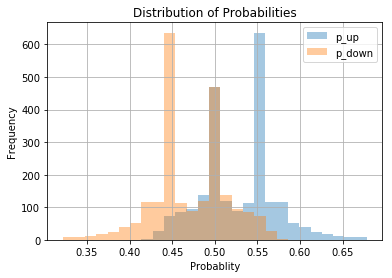

In [16]:
plt.figure()
test_data["p_up"].hist(bins=20, alpha=0.4)
test_data["p_down"].hist(bins=20, alpha=0.4)
plt.title("Distribution of Probabilities")
plt.legend(["p_up", "p_down"])
plt.ylabel("Frequency")
plt.xlabel("Probablity")
plt.show()

TRADING STATS
AVG Monthly Return :: 0.03%
STD Monthly        :: 2.94%
SHARPE             :: 0.03
MAX DRAWDOWN       :: 35.16%, 75.0 months
Correlation to SPY :: -0.00
NUMBER OF TRADES   :: 769
TOTAL TRADING DAYS :: 4277
SPY MONTHLY RETURN :: 0.76%
SPY STD RETURN     :: 4.44%
SPY SHARPE         :: 0.59
SPY DRAWDOWN       :: 55.37%, 8.0 months
0.351648055589


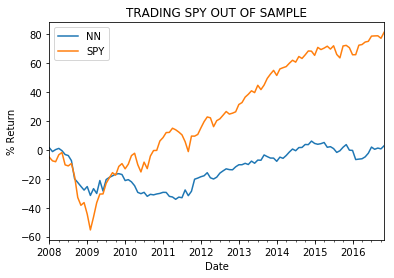

In [17]:
test_data["pnl"] = test_data["Adj Close"].diff().shift(-1).fillna(0)*test_data["positions"]/np.where(test_data["Adj Close"]!=0,test_data["Adj Close"],1)
test_data["perc"] = (test_data["Adj Close"] - test_data["Adj Close"].shift(1)) / test_data["Adj Close"].shift(1)
monthly = test_data.pnl.resample("M").sum()
monthly_spy = test_data["perc"].resample("M").sum()
avg_return = np.mean(monthly)
std_return = np.std(monthly)
sharpe = np.sqrt(12) * avg_return / std_return
drawdown = create_drawdowns(monthly.cumsum())
spy_drawdown = create_drawdowns(monthly_spy.cumsum())
print("TRADING STATS")
print("AVG Monthly Return :: " + "{0:.2f}".format(round(avg_return*100,2))+ "%")
print("STD Monthly        :: " + "{0:.2f}".format(round(std_return*100,2))+ "%")
print("SHARPE             :: " + "{0:.2f}".format(round(sharpe,2)))
print("MAX DRAWDOWN       :: " + "{0:.2f}".format(round(drawdown[0]*100,2)) + "%, " + str(drawdown[1]) + " months" )
print("Correlation to SPY :: " + "{0:.2f}".format(round(np.corrcoef(test_data["pnl"], test_data["diff"])[0][1],2)))
print("NUMBER OF TRADES   :: " + str(np.sum(test_data.positions.abs())))
print("TOTAL TRADING DAYS :: " + str(len(data)))
print("SPY MONTHLY RETURN :: " + "{0:.2f}".format(round(monthly_spy.mean()*100,2)) + "%")
print("SPY STD RETURN     :: " + "{0:.2f}".format(round(monthly_spy.std()*100,2)) + "%")
print("SPY SHARPE         :: " + "{0:.2f}".format(round(monthly_spy.mean()/monthly_spy.std()*np.sqrt(12),2)))
print("SPY DRAWDOWN       :: " + "{0:.2f}".format(round(spy_drawdown[0]*100,2)) + "%, "  + str(spy_drawdown[1]) + " months" )

print(drawdown[0])
(monthly.cumsum()*100).plot()
(monthly_spy.cumsum()*100).plot()
plt.legend(["NN", "SPY"],loc=2)
plt.ylabel("% Return")
plt.title("TRADING SPY OUT OF SAMPLE")
plt.show()

This plot shows the % returns when we trade using SPY and NN based models only when we are > 55% sure of the predicted directionality.

It is interesting to see here how the NN performs during the [financial crisis](https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008). This strategy makes money when many are losing ( refer to the dip in the green line in the plot between 2008-2010)! More importantly, this strategy has a significantly lower volatility (lower standard deviation in the blue line relative to the green line). 

In the summary statistic, you can also see a lower maximum drawdown of 13.62% for the NN model compared to the 55.37% for the SPY index over the same period of time. Similarly, a higher Sharpe ratio close to 1 from the NN model compared to 0.6 from the SPY index for the same period indicates the NN based decisions to be more stable (less risky). Thus, from a quant perspective it is more likely to be profitable (it makes money in many different market time periods). More importantly, the NN strategy is relatively uncorrelated with the SPY index (only 0.06 close to 0). 

**Suggested task**: Try to experiment with this network with different stocks and see what happens to the Sharpe ratio when you have multiple trading streams that are uncorrelated with each other. 

Remember when trading you can trade with leverage, and increase your return profile (as long as you are willing to handle the down times). The best trading strategies are the ones that can consistently make money no matter which market they are trading and no matter what is happening in the market. This "edge" is termed alpha in the quant industry.

It is important to notice how much of a drawdown you will experience when trading (http://www.investopedia.com/terms/m/maximum-drawdown-mdd.asp?lgl=no-infinite). Since our current model is calculating only the percentage returns where returns are not reinvested, and we are not holding but trading, the larger the drawdown the harder it is to recover (if you lost 90% of your portfolio then have a 90% gain, you will only be at 19% of your starting value). 

We can only predict on close prices and not the adjusted close prices since the adjusted close prices incorporate data from the future (such as stock splits and dividends) which can incorporate bias into our network. 

TRADING STATS
AVG Monthly Return :: -1.01%
STD Monthly        :: 7.03%
SHARPE             :: -0.50
MAX DRAWDOWN       :: 170.53%, 105.0 months
Correlation to SPY :: -0.05


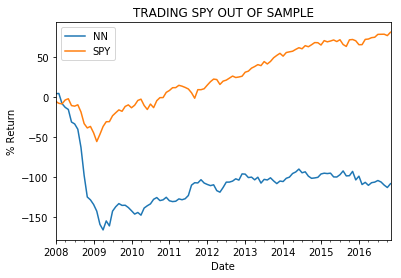

In [18]:
test_data["p_up"] = pd.Series(predicted_label_prob[:,0], index = test_data.index)
test_data["p_down"] = predicted_label_prob[:,1]
test_data['long_entries'] = np.where((test_data.p_up > 0.50) , 1, 0)
test_data['short_entries'] = np.where((test_data.p_down > 0.50) , -1, 0)
test_data['positions'] = test_data['long_entries'].fillna(0) + test_data['short_entries'].fillna(0)
test_data["pnl"] = test_data["Adj Close"].diff().shift(-1).fillna(0)*test_data["positions"]/np.where(test_data["Adj Close"]!=0,test_data["Adj Close"],1)
monthly = test_data.pnl.resample("M").sum()
avg_return = np.mean(monthly)
std_return = np.std(monthly)
sharpe = np.sqrt(12) * avg_return / std_return
drawdown = create_drawdowns(monthly.cumsum())

print("TRADING STATS")
print("AVG Monthly Return :: " + "{0:.2f}".format(round(avg_return*100,2))+ "%")
print("STD Monthly        :: " + "{0:.2f}".format(round(std_return*100,2))+ "%")
print("SHARPE             :: " +"{0:.2f}".format(round(sharpe,2)))
print("MAX DRAWDOWN       :: " + "{0:.2f}".format(round(drawdown[0]*100,2)) + "%, " + str(drawdown[1]) + " months" )
print("Correlation to SPY :: " + "{0:.2f}".format(round(np.corrcoef(test_data["pnl"], test_data["diff"])[0][1],2)))
(monthly.cumsum()*100).plot()
(monthly_spy.cumsum()*100).plot()
plt.legend(["NN", "SPY"],loc=2)
plt.ylabel("% Return")
plt.title("TRADING SPY OUT OF SAMPLE")
plt.show()

The plot above shows the % returns when we trade every day using SPY and NN based models as compared to a confidence based trading show in previous plot. With frequent trading the volatility is higher and transaction fees (not accounted in this plot) will greatly eat into any profits.


## Suggested exercises
Try changing the batch size, the network itself, the activation functions, and many other features and see how much it affects the output. Notice how it can change dramatically? This means what you have been training on might be noise and you need to refine either the model or more likely the inputs to the network itself. 

After you have completed the aforementioned exercise, experiment with applying the trained network to other to other timeseries data. Pick a stock in the S&P 500, pick something that is uncorrelated with the S&P 500, try a completely random dataset. How do you expect each of those to do? Should the performance match up with S&P 500 out of sample performance? How about the random data?


In [19]:
# Repeatable factor (used for runtime verification)
print(error)

0.49


## Appendix
A great resource for getting started as a Quant: https://www.quantstart.com/
An online back-testing and open source trading platform, hosts quant competitions and a forum: https://www.quantopian.com/
[A summary of backtesting and biases](https://www.quantstart.com/articles/successful-backtesting-of-algorithmic-trading-strategies-part-i)
[For those who want to automatically trade in python](https://github.com/blampe/IbPy)